In [1]:
from attention import AttentionLayer # from here https://github.com/thushv89/attention_keras/blob/master/layers/attention.py

In [2]:
import os
import re
import sys
import numpy as np
import pandas as pd
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 

from keras import backend as K, layers
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional

Using TensorFlow backend.


In [3]:
os.getcwd()

'C:\\Users\\Telahun\\Documents\\School\\CECS590 - Deep Learning\\Final Project'

In [4]:
data = pd.read_csv(os.getcwd() + '\\amazon-fine-food-reviews\\Reviews.csv')

In [5]:
data.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."


In [6]:
print("shape: ", data.shape)
data.info()

shape:  (568454, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [7]:
data.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [8]:
cleaning = data.drop_duplicates(subset=['Text'])
cleaning = data.dropna(axis=0)
print("shape: ", cleaning.shape)

shape:  (568411, 10)


In [9]:
## contrations to full formed phrase
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [10]:
def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text  ## html
    newString = re.sub(r'\([^)]*\)', '', newString)   ## parenthesis
    newString = re.sub('"','', newString)   ## quotes
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) ## non-alphabet letters
    newString = re.sub('[m]{2,}', 'mm', newString) 
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                ##removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [11]:
def clean_text(data, feature, index):
    cleaned = []
    count = data.shape[0]
    for i, text in enumerate(data[feature]):
        cleaned.append(text_cleaner(text, index))
        print(str(i/count*100) +"%", sep='', end='\r')
    return cleaned

In [12]:
cleaned_text = clean_text(cleaning, 'Text', 0)

In [13]:
cleaned_summary = clean_text(cleaning, 'Summary', 1)

In [14]:
## texts
cleaned_text[:3]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch']

In [15]:
## summaries
cleaned_summary[:3]

['good quality dog food', 'not as advertised', 'delight says it all']

In [16]:
cleaning['cleaned_text']=cleaned_text
cleaning['cleaned_summary']=cleaned_summary

In [17]:
cleaning.replace('', np.nan, inplace=True)
cleaning.dropna(axis=0,inplace=True)

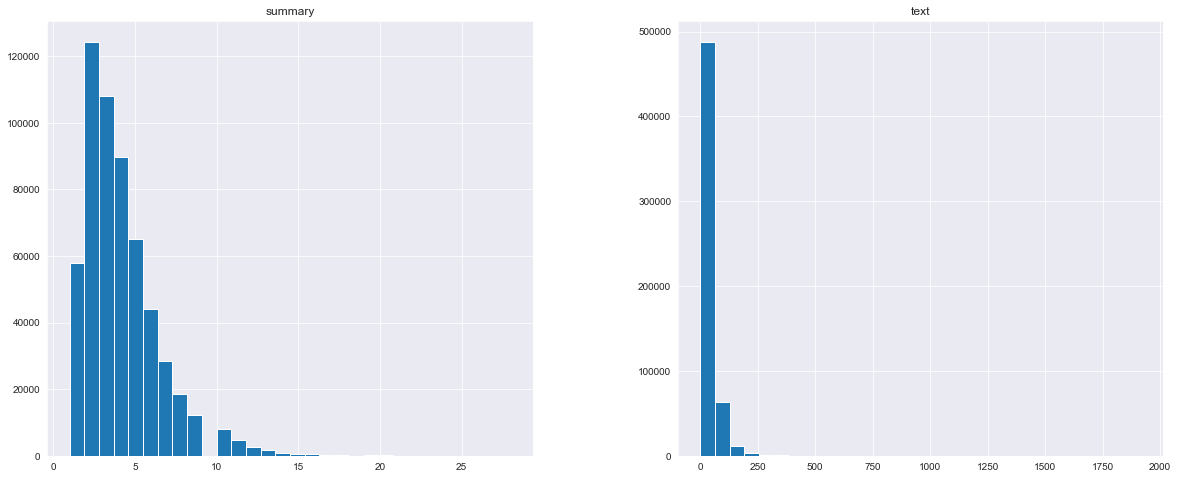

In [18]:
text_word_count = []
summary_word_count = []

for text in cleaning['cleaned_text']:
    text_word_count.append(len(text.split()))
    
for text in cleaning['cleaned_summary']:
    summary_word_count.append(len(text.split()))


length_df = pd.DataFrame({'text': text_word_count, 'summary': summary_word_count})
length_df.hist(bins=30, figsize=(20,8))
plt.show()

### Determine size of summaries and text

In [19]:
cnt=0
for i in cleaning['cleaned_summary']:
    if(len(i.split())<=10):
        cnt=cnt+1
print(cnt/len(cleaning['cleaned_summary']))

0.9796298546146681


In [20]:
cnt=0
for i in cleaning['cleaned_text']:
    if(len(i.split())<=140):
        cnt=cnt+1
print(cnt/len(cleaning['cleaned_text']))

0.9778849489117669


In [21]:
max_text_len=140 ##original tweet character limit
max_summary_len=10

In [22]:
cleaned_text =np.array(cleaning['cleaned_text'])
cleaned_summary=np.array(cleaning['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [23]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [24]:
df.head(2)

,text,summary
0,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,sostok good quality dog food eostok
1,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,sostok not as advertised eostok


### Splitting into train and test

In [25]:
x_train, x_val, y_train, y_val = train_test_split(np.array(df['text']), np.array(df['summary']), \
                                                  test_size=0.2, random_state=0, shuffle=True) 

### tokenize text

In [26]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

In [27]:
thresh=2

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 43.84752720927183
Total Coverage of rare words: 0.29215902833566204


In [28]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_train))

#convert text sequences into integer sequences
x_train_seq    =   x_tokenizer.texts_to_sequences(x_train) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_train    =   pad_sequences(x_train_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1
x_voc

55670

### tokenize summary

In [29]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_train))

In [30]:
thresh=2

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 42.915752988611445
Total Coverage of rare words: 0.48205445618306153


In [31]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_train))

#convert text sequences into integer sequences
y_train_seq    =   y_tokenizer.texts_to_sequences(y_train) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_train    =   pad_sequences(y_train_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
y_voc

16141

In [32]:
y_tokenizer.word_counts['sostok'],len(y_train) 

(436099, 436099)

In [33]:
## delete entries with just start and end tokens
ind=[]
for i in range(len(y_train)):
    cnt=0
    for j in y_train[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_train=np.delete(y_train,ind, axis=0)
x_train=np.delete(x_train,ind, axis=0)

In [34]:
## delete entries with just start and end tokens
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

### plotting

In [35]:
def plotloss(history_dict):
    acc = history_dict['acc']
    loss_values = history_dict['loss']
#     val_loss_values = history_dict['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(16, 10))
    plt.plot(epochs, loss_values, 'r', label='Training loss')
#     plt.plot(epochs, val_loss_values, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def plotacc(history):
    acc = history.history['acc']
#     val_acc = history.history['val_acc']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(16, 10))
    plt.plot(epochs, acc, 'r', label='Training acc')
#     plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### my computer doesn't like tensorflow after I play a game or use the gpu 

In [36]:
import gc
from numba import cuda

In [37]:
# K.clear_session()
# gc.collect()

# cuda.select_device(0)
# cuda.close()

In [36]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Gpus:", str(gpus))
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Gpus: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


## Model

In [37]:
K.clear_session()
    
latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim, trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 140)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 140, 100)     5567000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 140, 300), ( 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [121]:
model.load_weights('fp_m1_50.h5')

### Testing the model outputs

In [114]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [41]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [42]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [43]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [115]:
for i in range(0,100):
    print("Review:",seq2text(x_train[i]))
#     print("Original summary:",seq2summary(y_train[i]))
    print("Predicted summary:",decode_sequence(x_train[i].reshape(1,max_text_len)))
    print("\n")

Review: okay expecting crunchy type dried strawberries maybe missed something reading description also sweet son liked gave aware berries coated sugar 
Predicted summary:  not what expected


Review: yeast extract listed ingredient sounds harmless right specifically chips contain autolyzed yeast extract chemical level monosodium glutamate derived different source toxic properties kettle still advertises products containing msg acknowledge chips safe people msg sensitivities 
Predicted summary:  organic corn chips


Review: loved flowers however error order unable reach live person correct even though wrote email left several voice mails hour order placed still waiting refund order placed error soon battle guess used company past like product able contact anyone change order unsatisfying get promised refund use vendor 
Predicted summary:  great product but not the best


Review: searched decaf deep flavor great taste coffee barely miss caffeine since brewing glad found via amazon cannot

Predicted summary:  not the best


Review: love sooo delicious even better healing properties like oral tea tree oil cool altho consider one important medicinal things take day actually tsp morning night keep us healthy also protected bugs going around inside amazing used band aid like hold mouth swish around even gargle little swallowing savor flavor work anti germ viral magic mucous membranes also gets absorbed faster way friend mine mixes unique honey braggs apple cider vinegar part ultimate health strategy thank airborne amazon person purchased repeat customer long available think would make excellent unique christmas gift 
Predicted summary:  delicious


Review: good oil decent price want spend bit also like colavita extra virgin olive oil around always use subscription stop whenever want 
Predicted summary:  great olive oil


Review: water refreshing chilled refrigerator however tendency carry bottle til gone means might minutes perhaps hours care water room temperature metallic 

Predicted summary:  best hot sauce ever


Review: best quality real tic tac best flavor huge help weight loss ever immediate shipping affordable price real product back definitely 
Predicted summary:  best olive oil


Review: pleased packaging prompt delivery however every single package empty coffee inside broken seals holes nicely sealed empty cups would like coffee coffee 
Predicted summary:  great coffee


Review: using pearl barley inferior old batch product denmark maybe soil godd usa arrowhead much much better pearl barley product little flavor says producto denmark packed isreal like drinking dishwater would hate anyone new barley buy product flavor diluted biologist experience buy brand arrowhead barley good try huled lb bags make barley water drink first thing huled barley higher percent vitamins minerals barley good prevent uti helps acid refulx try drinking water lower th ph stomach leave lemon juice others add see make utube soak overnight boil mins strain put barley aside

Predicted summary:  stash chamomile herbal tea


Review: purchased tea set gift friend enjoys tea love tea creates flower clear teapot great gift 
Predicted summary:  great gift


Review: product tastes exactly like sugar use confidence knowing body react like would refined sugar love 
Predicted summary:  great product


Review: great mother got timely manner excited called told envy work mothers excited 
Predicted summary:  great product


Review: would perfect ground bit smaller big bite take long taste great 
Predicted summary:  great


Review: small dogs absolutely love greenies stores pets mart pet co want sale pack large always order amazon want spoil dogs great price keeping teeth white gums healthy 
Predicted summary:  great deal


Review: ordered two sets six boxes paid product came shock boxes yes boxes rip guess look matter quickly 
Predicted summary:  rip off


Review: little guys sure kick good pickled sausage juicy spicy perfect alarm clock wake taste buds surprised comme

### Predictions on Tweets

In [123]:
dataTwitter = pd.read_csv(os.getcwd() + '\\AAPLBatch2-25--3-16.csv')

In [124]:
dataTwitter.head(2)

,id,user_description,orig_text,text,user_name,user_followers,created,symbolval
0,1,"Know your edge. Take the trade.\n\nIf you don't know your edge, why are you trading? My stories are conceptually true. Names & locations changed. Trades are real.",$AAPL making the run at 280.\n\n(260 is next),AAPL making the run at 280\n\n260 is next,LettingGoSays,2012,2020-02-25 20:38:34.000000,AAPL
1,2,Trading Professionals Who Specialize in Live Technical & Swing Trading Alerts. DM for Info.,"Traders market right now, please trade fast, dont be afraid to take profits on both calls and puts, fast moving market, huge volatility , keep trades short term and fast! $SPY $AAPL $NFLX $FB $AMD",Traders market right now please trade fast dont be afraid to take profits on both calls and puts fast moving market huge volatility keep trades short term and fast SPY AAPL NFLX FB AMD,TheOptionsPros,1565,2020-02-25 20:38:37.000000,nosymbol


In [125]:
print("shape: ", dataTwitter.shape)
dataTwitter.info()

shape:  (17371, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17371 entries, 0 to 17370
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                17371 non-null  int64 
 1   user_description  15848 non-null  object
 2   orig_text         17371 non-null  object
 3   text              17371 non-null  object
 4   user_name         17371 non-null  object
 5   user_followers    17371 non-null  int64 
 6   created           17371 non-null  object
 7   symbolval         17371 non-null  object
dtypes: int64(2), object(6)
memory usage: 1.1+ MB


In [126]:
dataTwitter.describe()

,id,user_followers
count,17371.000000,1.737100e+04
mean,47577.805999,6.288931e+03
std,27480.363651,4.637471e+04
min,1.000000,0.000000e+00
25%,23502.500000,1.470000e+02
50%,46372.000000,7.500000e+02
75%,72484.500000,3.480000e+03
max,93182.000000,3.421751e+06


In [127]:
cleaningTweets = dataTwitter.drop_duplicates(subset=['text'])
cleaningTweets = dataTwitter.dropna(axis=0)

In [128]:
cleaned_text_tweets = clean_text(cleaningTweets, 'text', 0)
cleaned_text_tweets[:3]

cleaningTweets['cleaned_text']=cleaned_text_tweets

cleaningTweets.replace('', np.nan, inplace=True)
cleaningTweets.dropna(axis=0,inplace=True)


text_word_count = []
for text in cleaningTweets['cleaned_text']:
    text_word_count.append(len(text.split()))
    
cnt=0
for i in cleaningTweets['cleaned_text']:
    if(len(i.split())<=140):
        cnt=cnt+1

In [129]:
print(cnt/len(cleaningTweets['cleaned_text']*100))

1.0


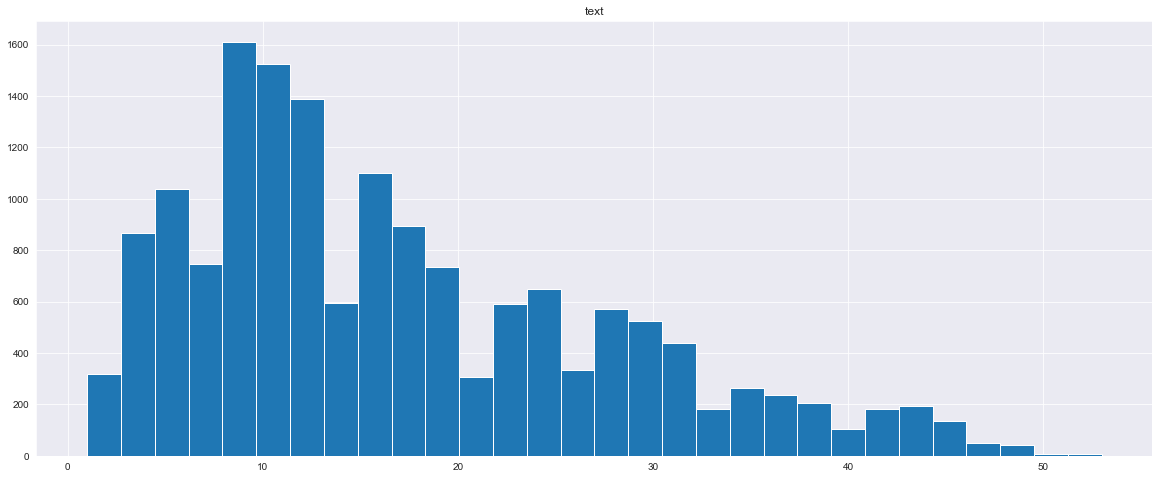

In [130]:
length_df = pd.DataFrame({'text': text_word_count})
length_df.hist(bins=30, figsize=(20,8))
plt.show()

In [131]:
cleaned_text_tweets =np.array(cleaningTweets['cleaned_text'])
short_text_Tweet=[]

for i in range(len(cleaned_text_tweets)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text_tweets[i].split())<=max_text_len):
        short_text_Tweet.append(cleaned_text_tweets[i])
#         short_summary.append(cleaned_summary[i])

df=pd.DataFrame({'text':short_text_Tweet})
df.head(3)

,text
0,aapl making run next
1,traders market right please trade fast dont afraid take profits calls puts fast moving market huge volatility keep trades short term fast spy aapl nflx fb amd
2,aapl ish lets end day strongtia


### Tokenize

In [132]:
x_train2 = df['text']
x_tokenizer2 = Tokenizer()
x_tokenizer2.fit_on_texts(list(x_train2))

thresh=2

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer2.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

#prepare a tokenizer for reviews on training data
x_tokenizer2 = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer2.fit_on_texts(list(x_train2))

#convert text sequences into integer sequences
x_train_seq2    =   x_tokenizer2.texts_to_sequences(x_train2) 
# x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_train2    =   pad_sequences(x_train_seq2,  maxlen=max_text_len, padding='post')
# x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc2   =  x_tokenizer2.num_words + 1
x_voc2

% of rare words in vocabulary: 46.022529322959
Total Coverage of rare words: 2.9991713114847145


9297

In [133]:
df['text'] = df['text'].apply(lambda x : 'sostok '+ x + ' eostok')
y_train2 = df['text']
y_tokenizer2 = Tokenizer()   
y_tokenizer2.fit_on_texts(list(y_train2))


thresh=2

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer2.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)


#prepare a tokenizer for reviews on training data
y_tokenizer2 = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer2.fit_on_texts(list(y_train2))

#convert text sequences into integer sequences
y_train_seq2    =   y_tokenizer2.texts_to_sequences(y_train2) 
# y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_train2    =   pad_sequences(y_train_seq2, maxlen=max_summary_len, padding='post')
# y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc2  =   y_tokenizer2.num_words +1
y_voc2

% of rare words in vocabulary: 46.01718532280539
Total Coverage of rare words: 2.6837138590830136


9299

In [134]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
#         sampled_token = reverse_target_word_index[sampled_token_index]

        try:
            sampled_token = reverse_target_word_index[sampled_token_index]
        except:
            sampled_token = '-x-'
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [135]:
reverse_target_word_index=y_tokenizer2.index_word
reverse_source_word_index=x_tokenizer2.index_word
target_word_index=y_tokenizer.word_index

In [138]:
for i in range(0,100):
    print("Tweet:",seq2text(x_train2[i]))
    #     print("Original summary:",seq2summary(y_train[i]))
    print("Predicted summary:",decode_sequence(x_train2[i].reshape(1,max_text_len)))
    print("\n")

Tweet: aapl making run next 
Predicted summary:  spy close sostok -x- -x- -x- -x- -x- -x-


Tweet: traders market right please trade fast dont afraid take profits calls puts fast moving market huge volatility keep trades short term fast spy aapl nflx fb amd 
Predicted summary: 


Tweet: aapl ish lets end day 
Predicted summary: 


Tweet: hours later feeling aapl 
Predicted summary:  tsla amzn mrk sostok -x- -x- -x- -x- -x-


Tweet: spy gspc aapl nflx goog tsla dow falls back day moving average brief bounce 
Predicted summary:  spy amd sostok -x- -x- -x- -x- -x- -x-


Tweet: aapl patent bandwidth management devices download multiple data streams tech ip research 
Predicted summary: 


Tweet: tptw captures billion worth contract billions federal government trading range going ibio nnvc kwbt tsla henc nio avxl aim ttnp aapl adxs tmus 
Predicted summary:  iwm new stocks sostok -x- -x- -x- -x- -x-


Tweet: time study warren buffetts annual letter berkshire hathaway shareholders performance 

Predicted summary:  spy coronavirus tsla


Tweet: aapl spy amzn new article two black swans get latest aapl related news 
Predicted summary: 


Tweet: aapl patent tech ip research 
Predicted summary:  spy us sostok -x- -x- -x- -x- -x- -x-


Tweet: grabbing aapl amzn lets see works two days row 
Predicted summary: 


Tweet: spom week imo sbes hdii clsi cyio zmrk keep loading related stocks run year otc alpp grfn sfor aapl msft amzn fb googl tsla amd 
Predicted summary: 


Tweet: looks terrible imo aapl 
Predicted summary: 


Tweet: aapl lows 
Predicted summary: 


Tweet: buys today stock investment nasdaq coronavirus investing wfc pfe aapl rds ibm mm wba dividendinvesting dividend 
Predicted summary: 


Tweet: coronavirus clouds apples timeline new iphones report aapl 
Predicted summary:  top sostok -x- -x- -x- -x- -x- -x- -x-


Tweet: aapl apple worries investing markets trading 
Predicted summary: 


Tweet: nio amd bac aapl uber spce us volume leaders 
Predicted summary: 


Tweet: vix